<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=130>

<CENTER>
</br>
<p><font size="6", color="#00B8DE">  UE Computational Imaging </font></p>
<p></p>
<p><font size="12">  Project Presentation : Graph Cut </font></p>
</p></br>
</p>
</CENTER>

---------------------------

*Groupe : Leguet Emmanuel, Sellami Aziz, Terrier Bérénice*

# <font color="#ABD03B"> Introduction </font>

Minimum cut/maximum flow algorithms on graphs emerged as a very useful tool for exact or approximate energy minimization in low-level vision. Powerful min-cut/max-flow algorithms from combinatorial optimization can be used to minimize certain important energy functions in vision. 

In most graph-based methods, the energies that we want to minimize can be represented as:


$$
E(L)=\sum_{p \in \mathcal{P}} D_{p}\left(L_{p}\right)+\sum_{(p, q) \in \mathcal{N}} V_{(p, q)} \cdot T\left(L_{p} \neq L_{q}\right)
$$
where $L = \{L_p | p ∈ \mathcal{P}\}$ is a labeling of image P, $D_p(·)$ is a data penalty function, $V_{p,q}$ is an interaction potential, and $\mathcal{N}$ is a set of all pairs of neighboring pixels which represents the "interactions" between the pixels and basically minimising this function provides a binary segmentation of the image.

Even if it can be used in many applications, we want to apply the graph cut method to image segmantation in our project.

*Example of Image Segmentation (source: paper 3)*

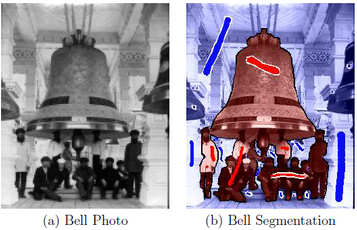


On the image below, we can see an illustration of what we implemented.

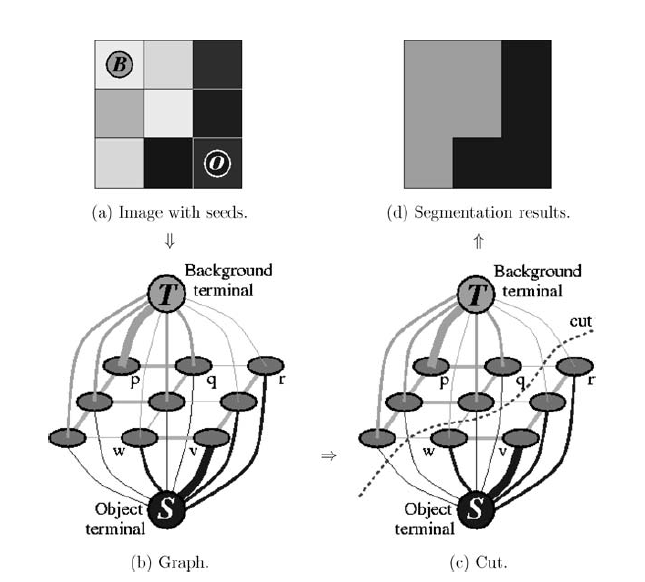

# <font color="#ABD03B"> Convert Image to Graph </font>

### Imports

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from Img2Graph import *
from PIL import Image
from Utils import *

### Example 1: Basic Image

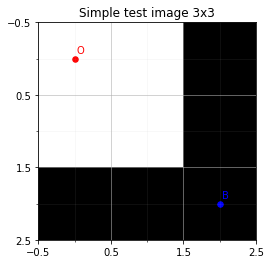

In [ ]:
img = np.zeros((3,3))
img[:2,:2] = 1
Simple_Image(img, 'gray', "Simple test image 3x3")

#### Convert to graph

In [ ]:
# Define priors
O = [(0,0)] # Prior Object - Source S
B = [(2,2)] # Prior Background - Sink T
priors = (O,B)

# To graph
G, Rp = image2graph(img, *priors, prior_as_index=True)

#### Visualize graph

##### Between pixels

<img src="images\Bpq.png">

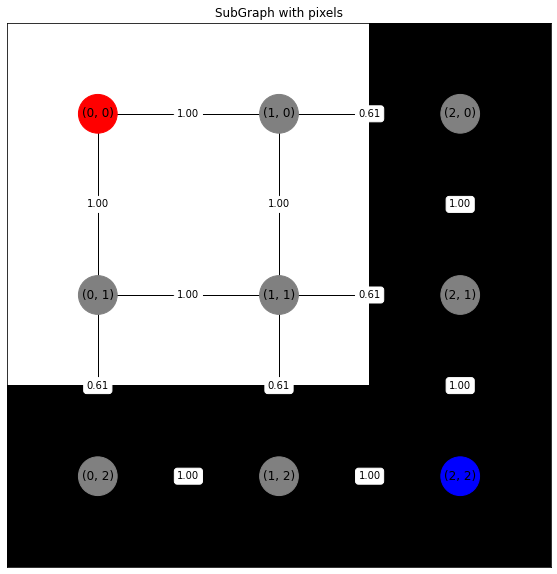

In [ ]:
G_sub = G.subgraph([n for n in G.nodes() if n not in ['T','S']])

plt.figure(figsize=(10,10))
plt.title('SubGraph with pixels')
pos=nx.spring_layout(G_sub)

new_pos = {p:[p[0],p[1]] for p in pos}
new_color = [{(0,0):'red', (2,2):'blue'}.get(p,'gray') for p in pos]

nx.draw_networkx(G_sub, new_pos, node_size=1500, node_color=new_color)
labels = {k:f'{v:.2f}'for (k,v) in nx.get_edge_attributes(G_sub,'capacity').items()}
nx.draw_networkx_edge_labels(G_sub, new_pos, edge_labels=labels, rotate=False)
plt.imshow(img, cmap='gray')
plt.show()

##### With terminals

<img src="images\Rp.png">

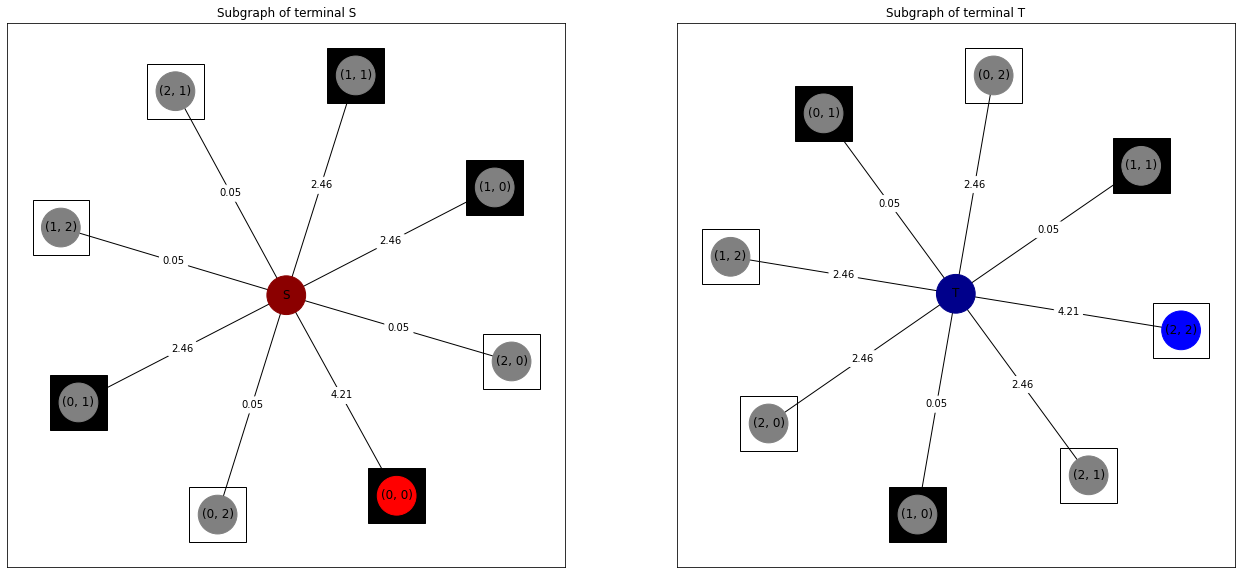

In [ ]:
plt.figure(figsize=(22,10))

for i,term in enumerate(['S', 'T']):
    ax = plt.subplot(1,2,i+1)
    plt.title(f"Subgraph of terminal {term}")

    G_sub_term = G.edge_subgraph([e for e in list(G.edges) if (e[0]==term or e[1]==term)])
    pos = nx.spring_layout(G_sub_term)
    term_col = {'S':'darkred', 'T':'darkblue'}[term]
    new_color = [{(0,0):'red', (2,2):'blue', term:term_col}.get(p,'gray') for p in pos]

    for p in pos:
        if p not in ["S", "T"]:
            rect = patches.Rectangle(pos[p]-.25/2, .25, .25, linewidth=1, edgecolor='black', facecolor='black', fill=int(img[p[0],p[1]]))
            ax.add_patch(rect)

    nx.draw_networkx(G_sub_term, pos, node_size=1500, node_color=new_color)
    labels = {k:f'{v:.2f}'for (k,v) in nx.get_edge_attributes(G_sub_term,'capacity').items()}
    nx.draw_networkx_edge_labels(G_sub_term, pos, edge_labels=labels, rotate=False)

plt.show()

##### Visualize the Regional Term

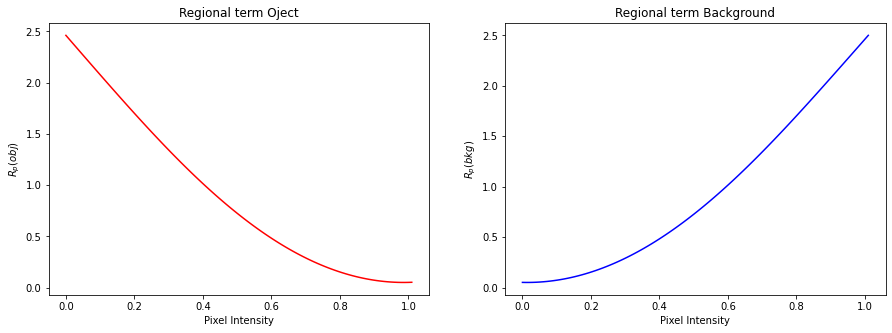

In [ ]:
visualize_Rp(Rp)

### Example 2: Cute Dog

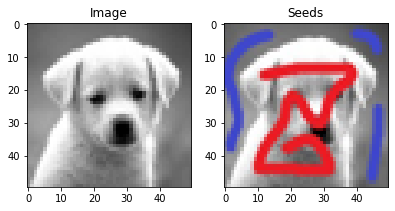

In [ ]:
W, H = 50,50
dog = np.array(Image.open('images/dog_small.jpg').convert('L').resize((W, H))) / 255
dog_painted = np.array(Image.open('images/dog_small_ST.jpg').convert('RGB').resize((W, H)))

priors = initialize_priors(dog_painted)

plt.figure(figsize=(10,7))
plt.subplot(131)
plt.title('Image')
plt.imshow(dog, cmap='gray')
plt.subplot(132)
plt.title('Seeds')
plt.imshow(dog_painted)
plt.show()

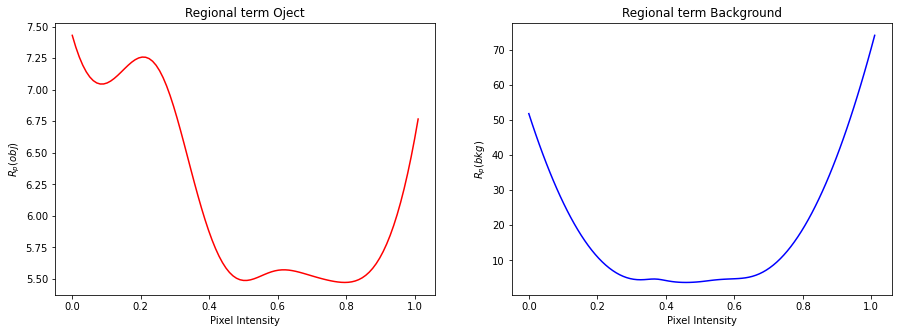

In [ ]:
G_dog, Rp = image2graph(dog, *priors, prior_as_index=True, σ=.1, λ=.1)
visualize_Rp(Rp)

# <font color="#ABD03B"> Graph Cut (our implementation) </font>

#### Imports

In [ ]:
from main import *
from IPython import display

#### MinCut-MaxFlow algorithm

In [ ]:
def GraphCut(Graph):

    # Initialisation
    Active = ['S','T']

    while True:
        # Grow a path
        Path = grow(Graph, Active)

        # End of the algo
        if not Path:
            break
        
        # Run the flow through the path
        Orphans = augment(Graph, Path)

        # Deal with orphans
        Active = adopt(Graph, Orphans, Active)

    return G

#### Example 1: Basic Image

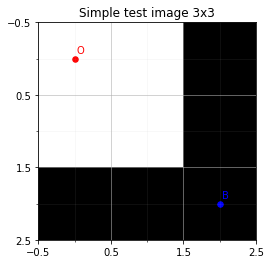

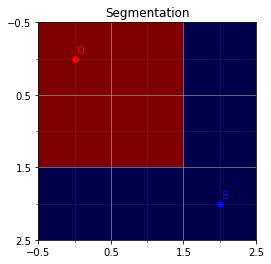

In [ ]:
# Run segmentation
segmentation = graph2img(segment(G), *img.shape)

Simple_Image(img, 'gray', "Simple test image 3x3")
Simple_Image(img, 'seismic', "Segmentation")

#### Example 2: Cute Dog

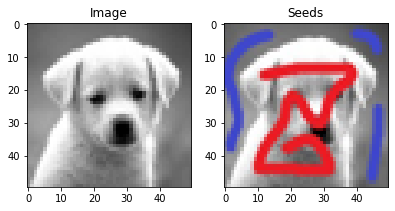

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(131)
plt.title('Image')
plt.imshow(dog, cmap='gray')
plt.subplot(132)
plt.title('Seeds')
plt.imshow(dog_painted)
plt.show()

In [ ]:
# Segment
G_dog, images  = segmentation_images(G_dog, dog)

# Create video
video = segmentation_animation(images, interval=50)

# Display video
html = display.HTML(video)
display.display(html)
plt.close()

# <font color="#ABD03B"> Graph Cut (library) </font>

Interface équivalente

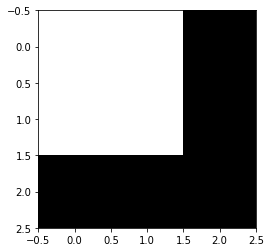

In [ ]:
G, Rp, nodeids=image2graph_lib(img, O,B,prior_as_index=True, nbins=10, σ=0.1, λ=0.1)
G.maxflow()
sgm = G.get_grid_segments(nodeids)
seg2 = np.int_(np.logical_not(sgm))
plt.imshow(seg2, cmap='gray')
plt.show()

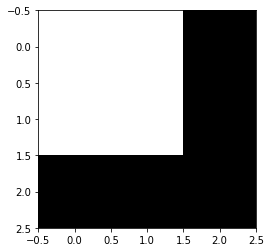

In [ ]:
G, Rp, nodeids=image2graph_lib(img, O,B,prior_as_index=True, nbins=10, σ=0.1, λ=0.1)
G.maxflow()
sgm = G.get_grid_segments(nodeids)
seg2 = np.int_(np.logical_not(sgm))
plt.imshow(seg2, cmap='gray')
plt.show()

# <font color="#ABD03B"> Benchmark </font>

In [ ]:
from imageio import imread, imwrite
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import rescale, resize, downscale_local_mean
import os
from glob import glob

In [ ]:
paths = [path for path in glob(os.path.join("dataset",'images',"*.jpg"))]
images = [np.array(rgb2gray(imread(path, as_gray=False, pilmode="RGB"))) for path in paths]
groundtruths = [np.array(rgb2gray(imread(path.replace('.jpg', '.png').replace('images','images-gt'), as_gray=False, pilmode="RGB"))) for path in paths]
labels = [np.array(imread(path.replace('.jpg', '-anno.png').replace('images','images-labels'), as_gray=False, pilmode="RGB")) for path in paths]

In [ ]:
def plot_img(imgs, nrow, ncol, figsize=10, legends=None, gray=True):
    fig, axs= plt.subplots(nrow, ncol, figsize=(figsize, figsize))
    n_tot=nrow*ncol
    for k in range(len(imgs)):
        idx=(k//ncol,k%ncol) if nrow>1 else k
        axs[idx].axis('off')
        if gray and len(imgs[k].shape)==2:
            axs[idx].imshow(imgs[k], cmap='gray')
        else:
            axs[idx].imshow(imgs[k])
        axs[idx].set_title(f"{legends[k]}")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


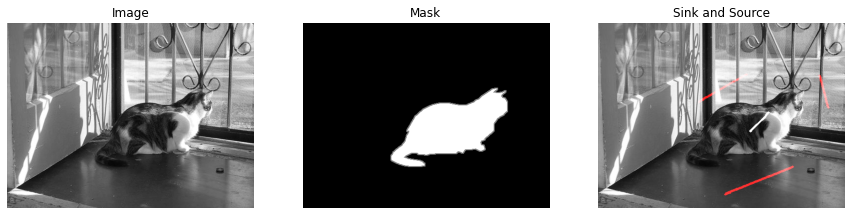

In [ ]:
idx=2
mask=labels[idx]!=0
img_and_label=gray2rgb(images[idx])
img_and_label[mask]=labels[idx][mask]
plot_img([images[idx], groundtruths[idx], img_and_label], 1, 3, figsize=15,legends=['Image', 'Mask', 'Sink and Source'])

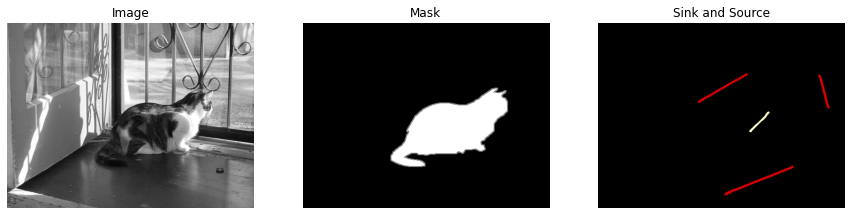

In [ ]:
plot_img([images[idx], groundtruths[idx], labels[idx]], 1, 3, figsize=15,legends=['Image', 'Mask', 'Sink and Source'])

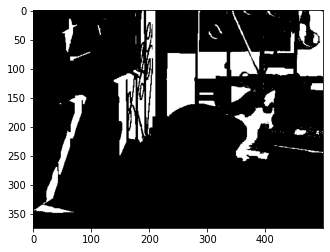

In [ ]:
def initialize_priors2(img_painted):
    """Image painted with red for Object and blue for Source.
        Return the Object and Background pixels."""
    red, green, blue = np.transpose(img_painted, (2,0,1))*255
    O_mask = (red > 50) * (green < 70) * (blue < 70)
    B_mask = (red < 80) * (green < 80) * (blue > 140)
    W_mask = (red > 70) * (green > 70) * (blue > 70)
    print(W_mask)
    O = [tuple(idx) for idx in np.argwhere(O_mask)]
    B = [tuple(idx) for idx in np.argwhere(W_mask)]
    return O, B
img=images[idx]
img = resize(img, (img.shape[0] // 4, img.shape[1] // 4),
                       anti_aliasing=True)
lbl = resize(labels[idx], (labels[idx].shape[0] // 4, labels[idx].shape[1] // 4,3),
                       anti_aliasing=True)
# plt.imshow(lbl)
# plt.show()
# source,sink=initialize_priors2(lbl)
# print(source, sink)
# print(len(source),source[0], len(sink))
# plt.plot(source, sink)
# plt.show()
G, Rp, nodeids=image2graph_lib(images[idx], source,sink,prior_as_index=True, nbins=10, σ=0.1, λ=0.1)
G.maxflow()
sgm = G.get_grid_segments(nodeids)
img2 = np.int_(np.logical_not(sgm))
plt.imshow(img2, cmap='gray')
plt.show()

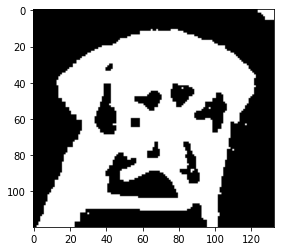

In [ ]:
img = np.array(rgb2gray(imread("images/dog_small.jpg")))
img_painted = np.array(imread("images/dog_small_ST.jpg"))
source,sink=initialize_priors(img_painted)
G, Rp, nodeids=image2graph_lib(img, source,sink,prior_as_index=True, nbins=10, σ=1, λ=1)
G.maxflow()
sgm = G.get_grid_segments(nodeids)
img2 = np.int_(np.logical_not(sgm))
plt.imshow(img2, cmap='gray')
plt.show()

Dice Metric (similarity):
$$
D S C=\frac{2|X \cap Y|}{|X|+|Y|}
$$

Some Results:

Image Name        : DICE

181079            : 80.9 %

cat_2008_001592   : 14.2 %

person_2007_000170: 52.6 %

person_2007_000323: 54.1 %


# <font color="#ABD03B"> Hyperparameters Exploration </font>

In [ ]:
from PIL import Image

sigmas = lambdas = [10**i for i in range(-3,3)]

W, H = 50,50
img = np.array(Image.open('images/dog_small.jpg').convert('L').resize((W, H))) / 255
img_painted = np.array(Image.open('images/dog_small_ST.jpg').convert('RGB').resize((W, H)))

priors = initialize_priors(img_painted)

results = []

for s in sigmas:
    for l in lambdas:
        G = image2graph(img, *priors, prior_as_index=True, σ=s, λ=l)[0]
        results.append(graph2img(segment(G), *img.shape))

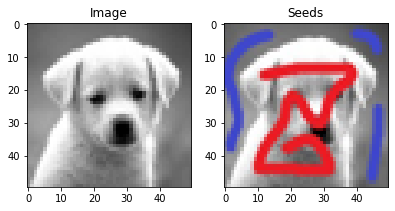

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(131)
plt.title('Image')
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.title('Seeds')
plt.imshow(img_painted)
plt.show()

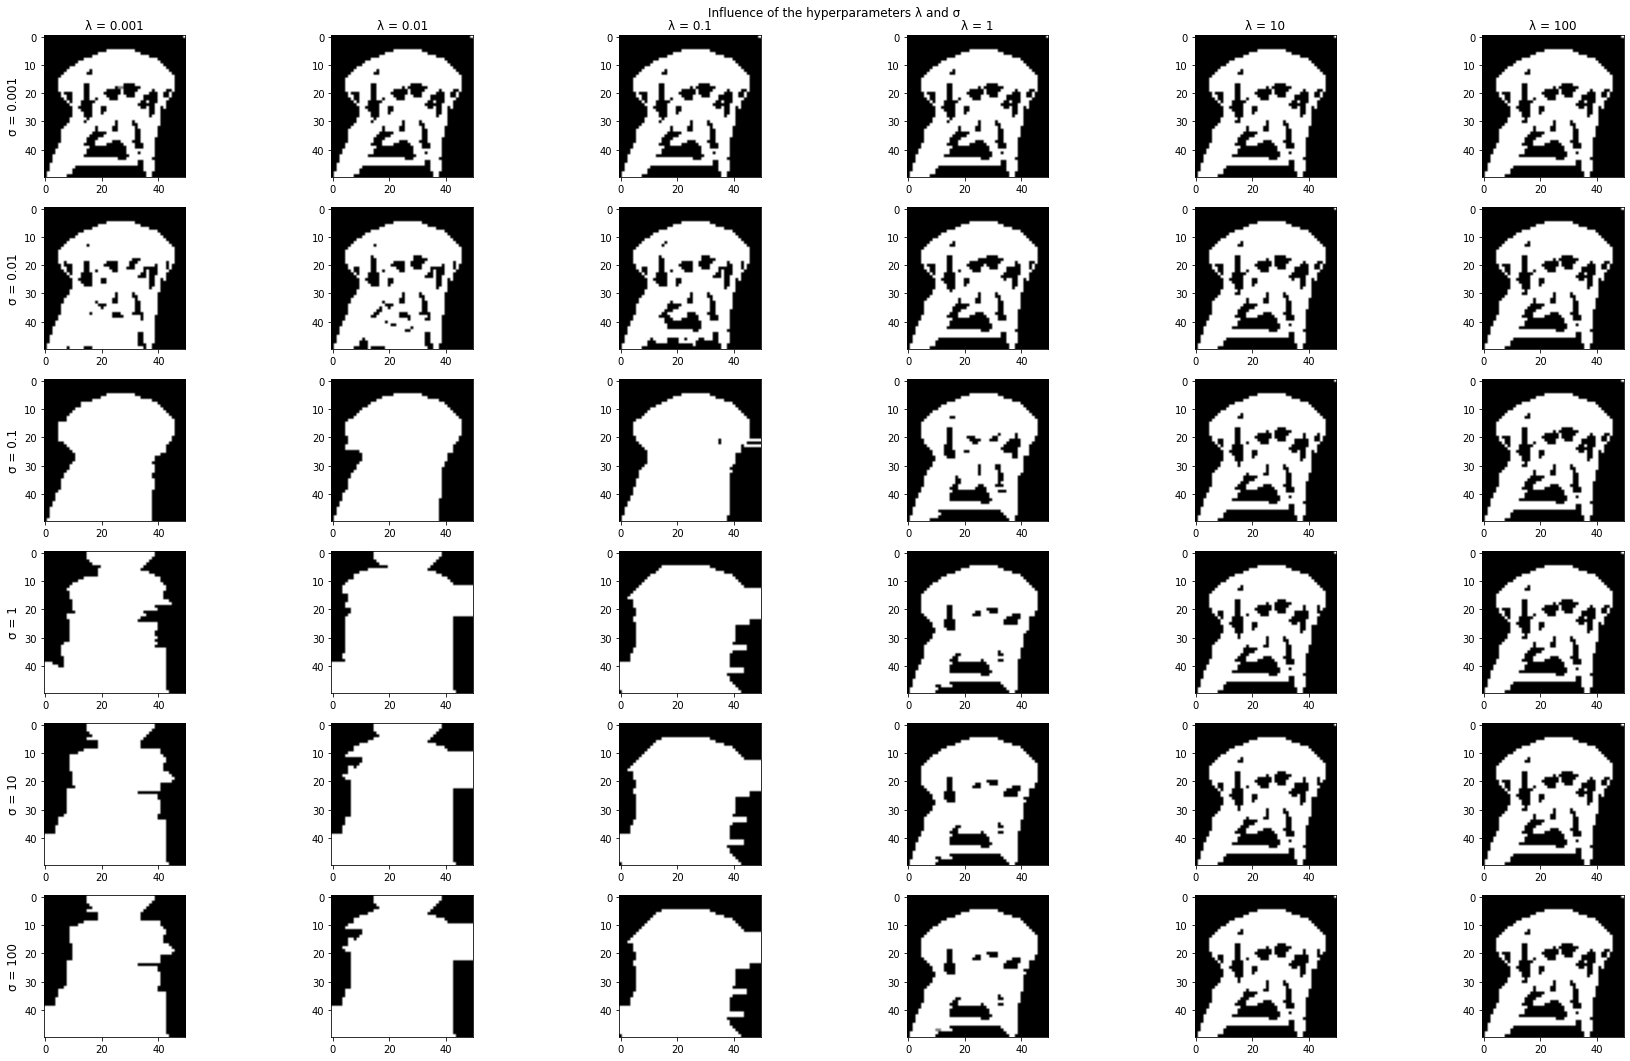

In [ ]:
rows = [f'σ = {s}' for s in sigmas]
cols = [f'λ = {l}' for l in lambdas]

fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), figsize=(25,15))
fig.suptitle("Influence of the hyperparameters λ and σ")

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

for i,ax in enumerate(axes.ravel()):
    ax.imshow(results[i], cmap='gray')

fig.tight_layout()
plt.show()